In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import math
#import scienceplots
#plt.style.use(['science','nature','no-latex','vibrant'])
from scipy import constants

#Import personal functions
import sys
#sys.path.append("C:/Users/Olivi/Documents/Git/SoRoMa/Thermal_Soft_Robotics/Functions")
#sys.path.append("C:/Users/Olivi/OneDrive - TU Eindhoven/Soft robotic matter/GitHub/Thermal_Soft_Robotics/Functions")
sys.path.append("//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Functions")
import FluidicSetupFunctions
from save_plot_func import save_plot
#import main_extended_functions 
from scipy.integrate import solve_ivp

from main_extended_functions import *

In [2]:

# Load constants 
k = constants.k # boltzman constant?
pi = constants.pi
sigmna = constants.sigma # Stefan–Boltzmann constant

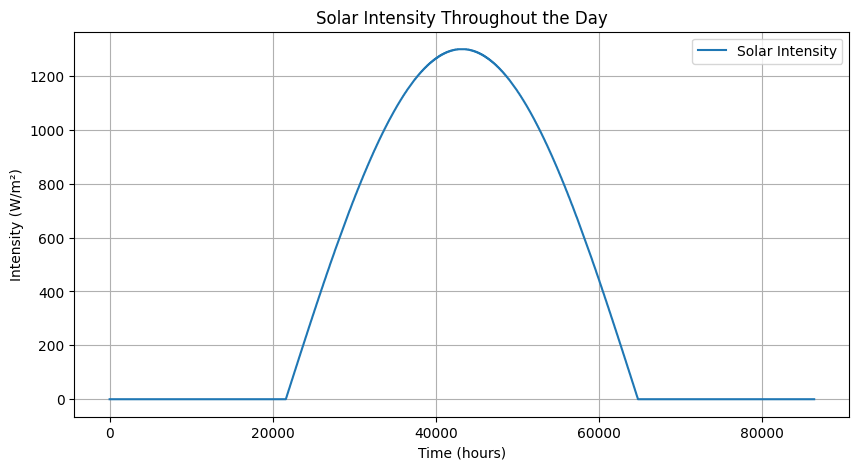

In [3]:
# Time array from 0 to 24 hours (one day)
t = np.linspace(0, 24*3600, 3600)

# Solar intensity function
def I(t, peak):
    if 6*3600 <= t <= 18*3600:
        return peak * np.sin((np.pi / (12*3600)) * (t - 6*3600))
    else:
        return 0

# Vectorize the function so it can operate on arrays
vectorized_solar_intensity = np.vectorize(I)

# Calculate intensity values
intensity = vectorized_solar_intensity(t, 1300)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(t, intensity, label="Solar Intensity")
plt.title("Solar Intensity Throughout the Day")
plt.xlabel("Time (hours)")
plt.ylabel("Intensity (W/m²)")
#plt.xticks(np.arange(0, 25*3600, 1))
plt.grid(True)
plt.legend()
plt.show()

In [4]:
def system(t, y, **params):
    T_g, T_co = y
  
    # Unpack parameters for use in the function
    alpha_g = params['alpha_g']
    A_g = params['A_g']
    t_g = params['t_g']
    rho_g = params['rho_g']
    c_g = params['c_g']
    epsilon_g = params['epsilon_g']
    m_g = params['m_g']

    alpha_c = params['alpha_c']
    k_c = params['k_c']
    r_c = params['r_c']
    h_c = params['h_c']
    A_c = params['A_c']
    t_c = params['t_c']
    A_ci = params['A_ci']
    A_con = params['A_con']
    rho_c = params['rho_c']
    m_c = params['m_c']
    c_c = params['c_c']
    tau_c = params['tau_c']
    epsilon_paint = params['epsilon_paint']

    rho_air = params['rho_air']
    V_air = params['V_air']
    c_air = params['c_air']

    A_p = params['A_p']
    n = params['n']

    T_s = params['T_s']
    T_amb = params['T_amb']
    v = params['v']
    I_peak = params['I_peak']

    T_air = 273.15 
    T_ci = T_co*(t_c/k_c)

    #Convection of the ground 
   
    h_cga = 5.7+3.8*v   # Convection from ground to ambient, formula 11 from paper # F 3.29a
    h_cgc = 0 # Convection from ground to container
    h_rgc =0# epsilon_paint*constants.sigma*(T_g**2+T_s**2)*(T_g+T_s) # Radiation from ground to container  
    h_rga  = epsilon_g*constants.sigma*(T_g**2+T_s**2)*(T_g+T_s) # Radiation from ground to ambient
    #delta_T = T_air-T_container # temperature difference between air and container

    #K_air = 5.75*10**-5*(1+0.00317*T_air-0.0000021*T_air**2) # Thermal conductivity of air,doi: https://sci-hub.se/https://doi.org/10.1071/CH9510305
    #h_cca = h_cpn(A_c, D_c,L, K_air, Cp_air,delta_T, mu_air, nu_air, beta_air )
    
    # Convection from container to enclosed air 
    h_cac = 0 #h_cac(v,2*r_c) # Convection from ambient to container outside 
    h_rcs = 0 #epsilon_paint*constants.sigma*(T_co**2+T_s**2)*(T_co+T_s) # Radiation from container to sky

    #Convetion in pouches 
    #h_cpn_g = h_cpn(A_pouch, D_p ,L_p, K_n, Cp_n,delta_T, mu_n, nu_n, beta_n)# Convection from pouch to novec gas 
    #h_cpn_l =h_cpn(A_pouch, D_p ,L_p, K_n, Cp_n,delta_T, mu_n, nu_n, beta_n) # Convection from pouch to novec liquid 
    
    #Convetion for enclosed air 
    #h_cap = h_cap(d_pouch, D_c)# Convection from air to pouch 

    # Calculate T_g based on the previous state and other factors
    # Convection from ground to ambient, formula 11 from paper # F 3.29a
    E_in_g = I(t,I_peak)*alpha_g*A_g 
    E_out_g = h_cga*A_g*(T_g-T_amb)+(t_c/k_c)*A_con*(T_g-T_co)+h_rga*(T_g-T_s)*A_g
    #dT_g_dt = machine_precision(num,den)
    dT_g_dt = (E_in_g-E_out_g)/(m_g*c_g)
 
    # Temperature of the pouch, T_p
    #num = (h_cpn_g+h_cpn_l)*T_n
    #den = h_cap+h_cpn_g+h_cpn_l
    #T_p = A_p*n*((h_cap*T_air+num)/den)

    #Temperaature of the outside of the container, T_co
    #M = rho_air*V_air*c_air
    
    E_in_c = A_c/2 *I(t,I_peak)*alpha_c+(t_c/k_c)*A_con*(T_g+T_co)
    h_cca = h_cpn(A_ci, 2*pi*r_c ,h_c, k_c, c_air,T_amb, T_ci ,rho_air)
    E_out_c = A_c/2*h_rcs*(T_co-T_s)+h_cca*A_c*(T_co-T_air)
    dT_co_dt  = (E_in_c-E_out_c)/(m_c*c_c)
    #dT_co_dt = machine_precision((num1+h_cac*T_amb),den1)

    # Analytical solution for T_air
    #a = h_cap*n*A_p+h_cca*A_ci -(k/t)*h_cap/B
    #f_t = I*tau_c*A_c/2-h_cca*A_ci*(k/t)*(A/B)-h_cap*n*A_p*D/G

    #dT_air_dt = (f_t - a*T_air) / M

    # Define equations for T_novec
    #M1 = rho_n*V_n*c_n

    #J = h_cpn_g+h_cpn_l
    #L = h_cpn_g+h_cpn_l + h_cap
    
    #a1 = h_cpn_g+h_cpn_l+A_p*n*J/L
    #f1_t = A_p*n(h_cpn_g+h_cpn_l)*(h_cap*T_air)/L

    #dT_n_dt = (f1_t - a1*T_n) / M1
    
    #return [dT_air_dt, dT_n_dt]
 
    print('t = ', t)

   
    
    return [dT_g_dt, dT_co_dt]
      

In [5]:
# System parameters 
# Ground 
alpha_g = 0.91 # Ashalth roofing, new https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html
A_g = 1 # Area ground [m^2]
t_g = 50e-3 # Thickness ground [m]
rho_g = 2.36e3 # Density ground [kg/m^3] https://www.engineeringtoolbox.com/density-solids-d_1265.html
m_g = rho_g*A_g*t_g # Mass ground [kg]
c_g = 920 # Specific heat capacity ground [J/kg/K] https://www.engineeringtoolbox.com/specific-heat-capacity-d_391.html
epsilon_g = 0.93 # Black body radiation [-] https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html

alpha_c =0.9 # absorption constant container 
k_c = 1200 # specific heat capacity container  ( J.K-1.kg-1 ) https://www.azom.com/article.aspx?ArticleID=2047

r_c = 0.1/2 # radius container
h_c = 0.3 # height container
A_c = 2*pi*r_c*h_c # Area container [m^2], assumed cilinder 
t_c= 3e-3 # thickness container
A_ci = 2*pi*(r_c-t)*(h_c-2*t_c)# Area inside container 
A_con = 0.01*A_c
rho_c  = 1.35e3 # density container [kg/m^3]
m_c = 2*pi*(r_c**2-(r_c-t_c)**2)*h_c*rho_c # Mass container [kg]
c_c = 1550 # Specific heat capacity polyethylene  [J/kg/K] https://www.engineeringtoolbox.com/specific-heat-polymers-d_1862.html
tau_c = 0.01 # Transmission of the sun through the container (assumed)
epsilon_paint= 0.9 # Black body radiation [-] https://help.covetool.com/en/articles/5560310-wall-emissivity
k_c = 0.50  # Thermal conductivity of the container (Polyethylene, high density (PEH)) [W/m/K] https://www.engineeringtoolbox.com/thermal-conductivity-plastics-d_1786.html


#Air properties 
rho_air = 1.293 # density air kg/m^3
V_air = 2*pi*(r_c-t_c)*h_c # Volume air in container
c_air= 	1.0035 # specific heat capacity air J/kg/K https://en.wikipedia.org/wiki/Table_of_specific_heat_capacities
 # specific heat capacity air J/kg/K https://en.wikipedia.org/wiki/Table_of_specific_heat_capacities

# Pouch properties
A_p = 200e-6 # Area pouch m^2 
n=1 # number of pouches


# Env properties
T_s = 20+273.15 # Temperature of the sky
T_amb = 20+273.15 # Temperature of the ambient air
v = 3 # Wind speed m/s
I_peak = 1300 # Peak intensity of the sun W/m^2




In [6]:
# Make dictionary of all constants 
# System parameters in a dictionary
params = {
    # Ground parameters
    "alpha_g": alpha_g,
    "A_g": A_g,
    "t_g": t_g,
    "rho_g": rho_g,
    "c_g": c_g,
    "epsilon_g": epsilon_g,
    # Calculate mass of ground based on other parameters
    "m_g": m_g,

    # Container parameters
    "alpha_c": alpha_c,
    "k_c": k_c,
    "r_c": r_c,
    "h_c": h_c,
    # Calculate area of container assumed cylinder
    "A_c": A_c,
    "t_c": t_c,
    # Calculate inner area of container
    "A_ci": A_ci,
    "A_con": A_con,
    "rho_c": rho_c,
    # Calculate mass of container
    "m_c": m_c,
    "c_c": c_c,
    "tau_c": tau_c,
    "epsilon_paint": epsilon_paint,

    # Air properties
    "rho_air": rho_air,
    # Calculate volume of air in container
    "V_air": V_air,
    "c_air": c_air,

    # Pouch properties
    "A_p": A_p,
    "n": n,

    # Environmental properties
    "T_s": T_s,
    "T_amb": T_amb,
    "v": v,
    "I_peak": I_peak,
}

In [13]:
def h_cpn(A, peri ,L, K, Cp,T_f, T_s, rho_air):
    # Calculates heat transfer coeefficient for free convection in closed cilinder 
    #System: horizontal cilinder

    # Inputs:
    # A: Area of cylinder
    # peri: perimeter of cylinder
    # mu: dynamic viscosity
    # K: thermal conductivity
    # Cp: specific heat capacity at constant pressure
    # T_f : temperature of fluid
    # T_s: temperature of surface
    # nu: kinematic viscosity
    # L: length of cylinder
    # beta: thermal expansion coefficient of the medium 

    #Retun: heat transfer coefficient
    C = 0.47
    n = 0.25
    K = 1

    X = A/peri
    delta_T = (T_f-T_s)
    beta = 1/(np.average([T_f,T_s])) # Formula 3.23 c
    Gr = (9.81*beta*delta_T*X**3)/(calc_nu(T_f,rho_air)**2) # Formula 3.22d
    print("beta:", beta, "Gr:", Gr, "n:", n, "X:", X, "delta_T:", delta_T, "nu:", calc_nu(T_f,rho_air)

    Pr = calc_mu(T_f)*Cp/K #formula 3.22c
    print("Gr:", Gr, "Pr:", Pr, "n:", n)
    h = (K/L)*C*((Gr*Pr)**n)*K
    return h

In [12]:
# Simulation settings 
#par_con = [A_c,A_ci, h_c, 2*r_c]]
#par_air = [K_air,Cp_air, nu_air, mu_air, beta_air]
#par_novec = [K_novec,Cp_novec, nu_novec, mu_novec, beta_novec]
#par_pouch = [A_pouch, peri_p, L_p, D_pouch]
#par_env = [v, T_sky, T_amb, I, alpha_g, alpha_c, epsilon_paint]



# Define initial conditions

y0 = [T_amb+20, T_amb]


t = np.linspace(0, 24*3600, 24*3600)
sol = solve_ivp(
    lambda t, y: system(t, y, **params),  # Unpack params here
    [t[0], t[-1]],
    y0,
    dense_output=True,
    method='RK45',
    t_eval=np.linspace(t[0], t[-1], 24*3600),
    rtol=1e-6,
    atol=1e-9,
    max_step=1
)
print(sol.message)
t= sol.t
y= sol.y   

beta: 0.006781755314946413
Gr: [ 2.50443227e+09 -2.75472689e+17 -2.21068799e+18 ... -1.29007668e+28
 -1.29115294e+28 -1.29222980e+28] Pr: 1.8198096146950455e-05 n: 0.25
t =  0.0


C:\Users\vaarkamp\AppData\Local\Temp\ipykernel_8748\4115032391.py:30: RuntimeWarning: invalid value encountered in power
  h = (K/L)*C*((Gr*Pr)**n)*K


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
T_g = y[0,:]
T_co = y[1,:]

# Create the primary axis (left y-axis)
fig, ax1 = plt.subplots()

# Plot T_g and T_co on the primary axis
ax1.plot(sol.t, T_g-273.15, label="Ground")
ax1.plot(sol.t, T_co-273.15, label="Container", marker="o")
ax1.hlines(T_amb-273.15, 0, 24*3600, label="Ambient", linestyle="dashed")
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature')
ax1.legend(loc='upper left')

# Create the secondary axis (right y-axis) sharing the same x-axis
ax2 = ax1.twinx()

# Plot intensity on the secondary axis
#t = np.linspace(0, 24*3600, 3600)
ax2.plot(np.linspace(0, 24*3600, 3600), intensity, label="Solar Intensity", color='r')
ax2.set_ylabel('Intensity')
ax2.legend(loc='upper right') 

plt.title('Temperature and Solar Intensity Over Time')
plt.show()